In this notebook we show trephine level Cellular Neighbourhoods lable per cell identified using cell charter

In [1]:
import os
from tqdm import tqdm
import spatialdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import anndata as ad

import sys
sys.path.append('..')
from configuration import STConfig
from wrappers.sdata_initalizer import SDataInitalizer
from wrappers.sdata_customizer import SDataCustomizer

from utils.utils_colors import cn_color_palette
from utils.utils_geom import align_sample_polygons

### Loading Configuration

In [2]:
cfg = STConfig()
meta_df = pd.read_csv(cfg.pth_meta_csv)
samples = meta_df['sample_key'].tolist()
print(f'Number of samples {len(samples)}')
print(samples)

Number of samples 32
['10693_R2', '10693_R1', '16832_R1', '16832_R2', '16818_R2', '16818_R1', '16818_R3', '18552_R3', '18552_R1', '18552_R2', '18550_R1', '18550_R3', '18550_R2', '18606_R2', '18606_R3', '18606_R1', '18599_R3', '18599_R1', '18599_R2', '18286_R3', '18286_R2', '18286_R1', '18256_R3', '18256_R1', '18256_R2', '18612_R1', '18612_R4', '18612_R2', '18612_R3', '18669_R3', '18669_R2', '18669_R1']


In [3]:
adata = ad.read_h5ad(cfg.pth_cell_charter_cn)
adata

AnnData object with n_obs × n_vars = 4321588 × 377
    obs: 'region', 'slide', 'cell_id', 'area', 'cell_status', 'meg_phenotype', 'annotation', 'it_regions', 'mutation_status', 'run', 'study_id', 'diagnosis', 'diagnosis2', 'broad_diagnosis', 'SCT_snn_res.0.3', 'clusters', 'clusters_w_megs', 'new_clusters', 'new_clusters_w_megs', 'region_name', 'new_cell_status', 'extra_new_cell_status', 'final_anno_l1', 'final_anno_l2', 'final_anno_l3', 'final_anno_l4', 'final_anno_l5', 'final_anno_l1_stromal_refined', 'final_anno_l2_stromal_refined', 'final_anno_l3_stromal_refined', 'final_anno_l4_stromal_refined', 'final_anno_l5_stromal_refined', 'sample_id', 'batch', 'obj.anno_3_w_megs', 'obj.anno_3_w_megs_w_stromal', '_scvi_batch', '_scvi_labels', 'cluster_cellcharter', 'cluster_cellcharter_n5'
    uns: '_cellcharter', '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'spatial_neighbors'
    obsm: 'X_cellcharter', 'X_scVI', 'spatial'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_dist

### Reading Neighbourhood Info of Each Cell

In [7]:
# reading cell annotation 
skey = 'sample_id'
cn_type_col = 'cluster_cellcharter'
annot_df = adata.obs.loc[:, [skey ,cn_type_col]].copy()
print(annot_df[cn_type_col].unique())
annot_df.head(2)

[0, 1]
Categories (2, int64): [0, 1]


,sample_id,cluster_cellcharter
aacjofpg-1_18286_R1,18286_R1,0
aacjpbeo-1_18286_R1,18286_R1,1


### Visualizing Cells coloured by Cellular Neighbourhoods

0it [00:00, ?it/s]

Visualizing Manual Annotation for sample 18256_R1


/tmp/slurm-2157431/ipykernel_249156/2264599026.py:32: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  plot_df.plot(


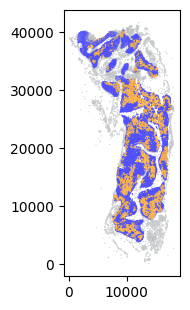

1it [07:19, 439.89s/it]

Visualizing Manual Annotation for sample 18552_R1


/tmp/slurm-2157431/ipykernel_249156/2264599026.py:32: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  plot_df.plot(


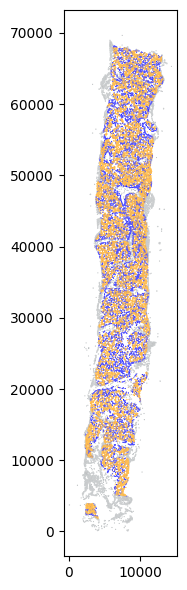

2it [09:29, 257.38s/it]

Visualizing Manual Annotation for sample 18256_R1


/tmp/slurm-2157431/ipykernel_249156/2264599026.py:32: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  plot_df.plot(


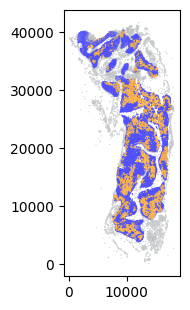

3it [16:37, 335.45s/it]

Visualizing Manual Annotation for sample 18286_R1


/tmp/slurm-2157431/ipykernel_249156/2264599026.py:32: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  plot_df.plot(


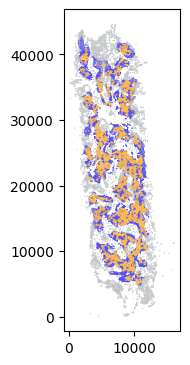

4it [19:59, 282.66s/it]

Visualizing Manual Annotation for sample 18550_R2


/tmp/slurm-2157431/ipykernel_249156/2264599026.py:32: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  plot_df.plot(


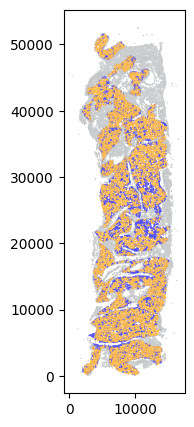

5it [24:39, 295.91s/it]


In [8]:
# To make notebook size managable we show only 3 random samples
N_samples = 5
samples = np.array(samples)


samples = list(samples[np.random.randint(0, len(samples), N_samples)])
if '10693_R1' in samples:
    samples = samples +['10693_R1']

figsize = (2, 6)   

cell_color_dict_rgb = {
    k: mcolors.to_rgba(v) 
    for k, v in cn_color_palette.items()
}

for idx, sample_id in tqdm(enumerate(samples)):
    print(f'Visualizing Manual Annotation for sample {sample_id}')
    customizer = SDataCustomizer(config=cfg, sample_key=sample_id)
    sdata_file_path = f'{cfg.pth_sdata}/{sample_id}_no_he.zarr'
    sdata_obj = spatialdata.read_zarr(sdata_file_path)

    gdf_cell_boundaries = sdata_obj['new_cell_boundaries'].copy()
    df_cntype = annot_df[annot_df[skey]==sample_id].copy()
    df_cntype[cn_type_col] = df_cntype[cn_type_col].astype('str')
    plot_df = gdf_cell_boundaries.merge(df_cntype, left_index=True, right_index=True, how='left')
    plot_df = align_sample_polygons(plot_df)
    plot_df[cn_type_col] = plot_df[cn_type_col].fillna('Unknown')
           
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    plot_df = plot_df.set_geometry("geometry_aligned")
    plot_df.plot(
        column = cn_type_col, 
        color = plot_df[cn_type_col].map(cell_color_dict_rgb),
        ax=ax
    )
    plt.tight_layout()
    plt.show()
